<a href="https://colab.research.google.com/github/Nikita1623/Python_aspect-based-sentiment-analysis/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk
!pip install seaborn
!pip install spacy
!pip install gensim
!pip install pyLDAvis
!pip install openpyxl
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import spacy
import gensim
from gensim import corpora
import pyLDAvis.gensim
import nltk

# Download NLTK stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()

import io
# Print the names of the uploaded files
for file_name in uploaded.keys():
    print(file_name)

# Load the Excel file (ensure the file name matches one of the printed names)
df = pd.read_excel(io.BytesIO(uploaded[file_name]), header=1)  # Use header=1 to read the second row as header


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sr No.,Review Id,User Name,Content,Rating,Sentiment,Unnamed: 6,Rating.1,Unnamed: 8,Unnamed: 9,Unnamed: 10,Sentiment.1,Unnamed: 12
0,1,aa864320-1679-4b67-8ec6-b8271c07685b,Subhadeep Dey,It has been over three years since the Flutter...,2.0,0.0,NaN,5,59.0,NaN,NaN,Positive,1.0
1,2,df7cc2c4-4dea-427f-a30a-64ed81e166fa,Invitation code- 4C6MTD,Very impressive! Although there is a problem w...,5.0,1.0,NaN,4,30.0,NaN,NaN,Negative,0.0
2,3,740b28b1-1692-40ed-baf7-fe492f4ecd65,Refer code- 6628IR à¤¡à¤¾à¤²à¥‡ ð–©¥00à¤°à¥ à...,"This app is are great, although there hasn't b...",5.0,1.0,NaN,3,40.0,NaN,NaN,NaN,NaN
3,4,cffa1994-02d8-4c58-b387-b82df504bf58,Athene Refer Code:- aa40c739a6,"Best And Superfast App...But, not working prop...",4.0,1.0,NaN,2,40.0,NaN,NaN,NaN,NaN
4,5,16df9b36-a2ad-46be-9166-976fe735b5bd,Refer Code:- 7â¾27âž‡623,"Hi, After the last update, I'm not able to ope...",5.0,1.0,NaN,1,229.0,NaN,NaN,NaN,NaN


In [ ]:
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    # selecting top most frequent words
    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(20, 5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel='Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Ensure all entries are strings
df['Content'] = df['Content'].astype(str)

# Replace "n't" with " not"
df['Content'] = df['Content'].str.replace("n\'t", " not")

# Remove unwanted characters, numbers, and symbols
df['Content'] = df['Content'].str.replace("[^a-zA-Z#]", " ")

# Remove short words (length < 3)
df['Content'] = df['Content'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

# Remove stopwords
stop_words = stopwords.words('english')

def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

df['Content'] = df['Content'].apply(lambda x: remove_stopwords(x.split()))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Function to keep only top 10 words by frequency in each review
def top_n_words(rev, n=10):
    words = rev.split()
    fdist = FreqDist(words)
    top_words = [word for word, count in fdist.most_common(n)]
    return ' '.join(top_words)

df['Content'] = df['Content'].apply(top_n_words)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

tokenized_reviews = pd.Series(df['Content']).apply(lambda x: x.split())
reviews_2 = lemmatization(tokenized_reviews)

reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-33-5162765bd2ff>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


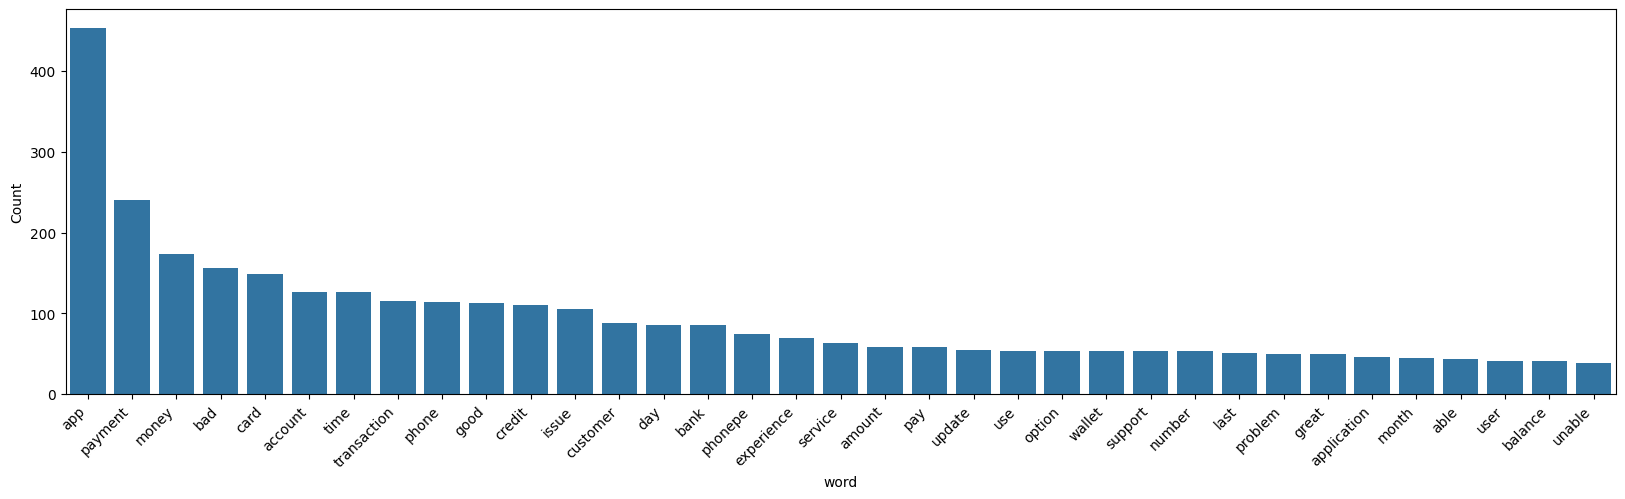

In [ ]:
freq_words(df['reviews'], 35)


In [ ]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7,
                random_state=100,
                chunksize=1000,
                passes=50)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.save_html(vis, 'lda_vis.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import files
files.download('lda_vis.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the processed reviews and aspect keywords to an Excel file
output_filename = "processed_reviews_and_aspect_keywords.xlsx"
with pd.ExcelWriter(output_filename) as writer:
    df.to_excel(writer, sheet_name='Processed_Reviews', index=False)

# Download the file
from google.colab import files
files.download(output_filename)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>